In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.linear_model import BayesianRidge, QuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility

In [2]:
import pandas as pd
renewable_data = pd.read_csv('/home/joseph/Downloads/Renewable.csv')
renewable_data_head = renewable_data.head()
renewable_data_info = renewable_data.info()
# Check basic info to see column types and any missing values
renewable_data_info
renewable_data_head,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    196776 non-null  object 
 1   Energy delta[Wh]        196776 non-null  int64  
 2   GHI                     196776 non-null  float64
 3   temp                    196776 non-null  float64
 4   pressure                196776 non-null  int64  
 5   humidity                196776 non-null  int64  
 6   wind_speed              196776 non-null  float64
 7   rain_1h                 196776 non-null  float64
 8   snow_1h                 196776 non-null  float64
 9   clouds_all              196776 non-null  int64  
 10  isSun                   196776 non-null  int64  
 11  sunlightTime            196776 non-null  int64  
 12  dayLength               196776 non-null  int64  
 13  SunlightTime/daylength  196776 non-null  float64
 14  weather_type        

(                  Time  Energy delta[Wh]  GHI  temp  pressure  humidity  \
 0  2017-01-01 00:00:00                 0  0.0   1.6      1021       100   
 1  2017-01-01 00:15:00                 0  0.0   1.6      1021       100   
 2  2017-01-01 00:30:00                 0  0.0   1.6      1021       100   
 3  2017-01-01 00:45:00                 0  0.0   1.6      1021       100   
 4  2017-01-01 01:00:00                 0  0.0   1.7      1020       100   
 
    wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  dayLength  \
 0         4.9      0.0      0.0         100      0             0        450   
 1         4.9      0.0      0.0         100      0             0        450   
 2         4.9      0.0      0.0         100      0             0        450   
 3         4.9      0.0      0.0         100      0             0        450   
 4         5.2      0.0      0.0         100      0             0        450   
 
    SunlightTime/daylength  weather_type  hour  month  
 0  

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

renewable_data['Time'] = pd.to_datetime(renewable_data['Time'])
renewable_data_cleaned = renewable_data.drop_duplicates()
renewable_data_cleaned['Energy delta[Wh]'] = renewable_data_cleaned['Energy delta[Wh]'].clip(upper=5020)
renewable_data_cleaned['GHI'] = renewable_data_cleaned['GHI'].clip(upper=229.2)
renewable_data_cleaned['temp'] = renewable_data_cleaned['temp'].clip(lower=-16.6, upper=35.8)
scaler = MinMaxScaler()
columns_to_scale = ['Energy delta[Wh]', 'GHI', 'temp', 'wind_speed', 'humidity']
renewable_data_cleaned[columns_to_scale] = scaler.fit_transform(renewable_data_cleaned[columns_to_scale])
renewable_data_cleaned['day_of_week'] = renewable_data_cleaned['Time'].dt.dayofweek
renewable_data_cleaned['hour_of_day'] = renewable_data_cleaned['Time'].dt.hour
renewable_data_cleaned['season'] = renewable_data_cleaned['month'].apply(lambda x: (x%12 + 3)//3)
renewable_data['Time'] = pd.to_datetime(renewable_data['Time'])
renewable_data_cleaned = renewable_data.drop_duplicates()
ordinal_encoder = OrdinalEncoder()
renewable_data_cleaned['weather_type'] = ordinal_encoder.fit_transform(renewable_data_cleaned[['weather_type']])
renewable_data_cleaned['lag_1'] = renewable_data_cleaned['Energy delta[Wh]'].shift(1)
renewable_data_cleaned['lag_2'] = renewable_data_cleaned['Energy delta[Wh]'].shift(2)
renewable_data_cleaned['rolling_mean_24'] = renewable_data_cleaned['Energy delta[Wh]'].rolling(window=24).mean()
renewable_data_cleaned = renewable_data_cleaned.dropna()
renewable_data_cleaned.head(), renewable_data_cleaned.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 196753 entries, 23 to 196775
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    196753 non-null  datetime64[ns]
 1   Energy delta[Wh]        196753 non-null  int64         
 2   GHI                     196753 non-null  float64       
 3   temp                    196753 non-null  float64       
 4   pressure                196753 non-null  int64         
 5   humidity                196753 non-null  int64         
 6   wind_speed              196753 non-null  float64       
 7   rain_1h                 196753 non-null  float64       
 8   snow_1h                 196753 non-null  float64       
 9   clouds_all              196753 non-null  int64         
 10  isSun                   196753 non-null  int64         
 11  sunlightTime            196753 non-null  int64         
 12  dayLength               19675

(                  Time  Energy delta[Wh]  GHI  temp  pressure  humidity  \
 23 2017-01-01 05:45:00                 0  0.0   2.6      1017       100   
 24 2017-01-01 06:00:00                 0  0.0   2.8      1017       100   
 25 2017-01-01 06:15:00                 0  0.0   2.8      1017       100   
 26 2017-01-01 06:30:00                 0  0.0   2.8      1017       100   
 27 2017-01-01 06:45:00                 0  0.0   2.8      1017       100   
 
     wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  dayLength  \
 23         5.7      0.0      0.0         100      0             0        450   
 24         6.0      0.0      0.0         100      0             0        450   
 25         6.0      0.0      0.0         100      0             0        450   
 26         6.0      0.0      0.0         100      0             0        450   
 27         6.0      0.0      0.0         100      0             0        450   
 
     SunlightTime/daylength  weather_type  hour  month

In [4]:
# Time-based split: We want to avoid future data leakage.
renewable_data_cleaned = renewable_data_cleaned.sort_values('Time')

# Define the split sizes (70% for training, 15% for validation, 15% for testing)
train_size = int(0.7 * len(renewable_data_cleaned))  # 70% for training
validation_size = int(0.15 * len(renewable_data_cleaned))  # 15% for validation
test_size = len(renewable_data_cleaned) - train_size - validation_size  # Remaining 15% for testing

# Splitting the data into train, validation, and test sets
train_data = renewable_data_cleaned[:train_size]
validation_data = renewable_data_cleaned[train_size:train_size + validation_size]
test_data = renewable_data_cleaned[train_size + validation_size:]
train_data.head(), validation_data.head(), test_data.head()


(                  Time  Energy delta[Wh]  GHI  temp  pressure  humidity  \
 23 2017-01-01 05:45:00                 0  0.0   2.6      1017       100   
 24 2017-01-01 06:00:00                 0  0.0   2.8      1017       100   
 25 2017-01-01 06:15:00                 0  0.0   2.8      1017       100   
 26 2017-01-01 06:30:00                 0  0.0   2.8      1017       100   
 27 2017-01-01 06:45:00                 0  0.0   2.8      1017       100   
 
     wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  dayLength  \
 23         5.7      0.0      0.0         100      0             0        450   
 24         6.0      0.0      0.0         100      0             0        450   
 25         6.0      0.0      0.0         100      0             0        450   
 26         6.0      0.0      0.0         100      0             0        450   
 27         6.0      0.0      0.0         100      0             0        450   
 
     SunlightTime/daylength  weather_type  hour  month

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
import random
import os


In [6]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    # For some older TF versions
    try:
        tf.config.experimental.enable_op_determinism()
    except:
        pass
# Ensure consistent datatypes by setting TensorFlow's default float type
tf.keras.backend.set_floatx('float32')

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 40)

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

Training data shape: (137727, 18) (137727,)
Validation data shape: (29512, 18) (29512,)
Test data shape: (29514, 18) (29514,)
Target value range: 0 - 4913
Target value mean and std: 569.809979161675 1048.7740820078607
Y scaler mean: [569.80997916]
Y scaler scale: [1048.77027456]
Initializing CWGAN model...
Training CWGAN model with validation...
Epoch 0/100 [D loss: 0.6739] [G loss: 8.4202] [Val MSE: 0.0811]
Epoch 5/100 [D loss: 0.0899] [G loss: 2.9089] [Val MSE: 0.0712]
Epoch 10/100 [D loss: 0.1360] [G loss: 6.5043] [Val MSE: 0.1213]
Epoch 15/100 [D loss: 0.0674] [G loss: 14.9072] [Val MSE: 0.0712]
Early stopping at epoch 16. Best epoch was 1 with validation MSE 0.0708


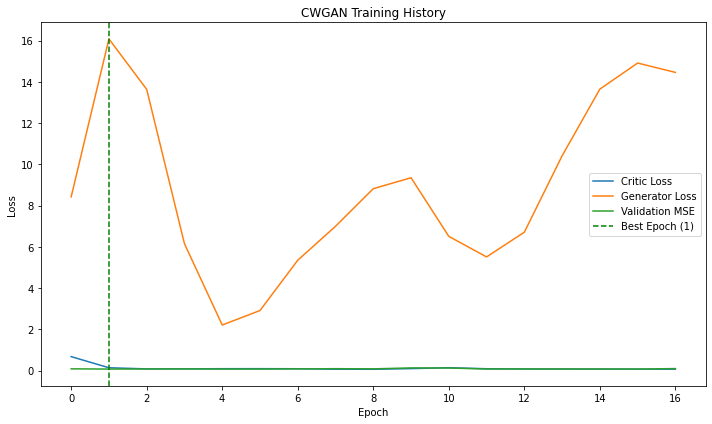

Generating predictions...

Metrics on SCALED data:
CWGAN (Time-based Split - Scaled) Performance:
MSE: 0.0676
RMSE: 0.2601
MAE: 0.1200
R²: 0.9322
----------------------------------------


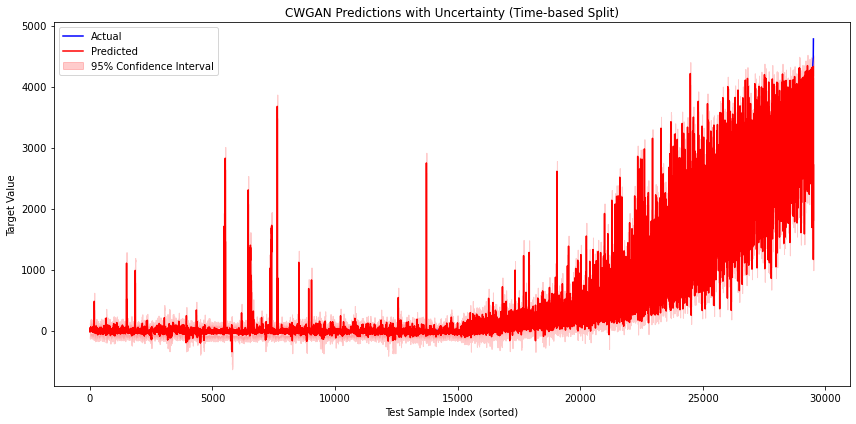

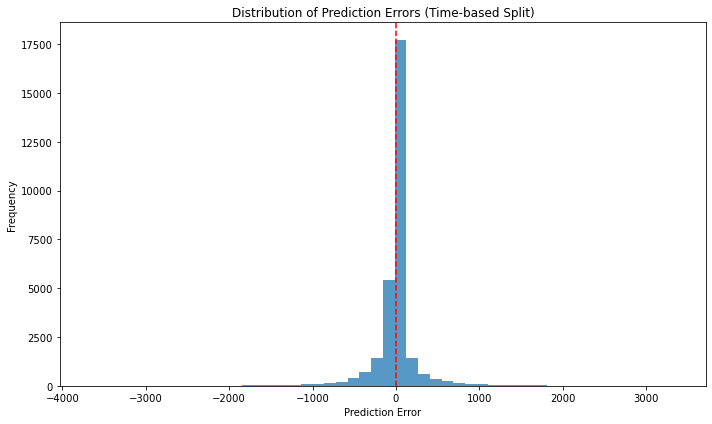

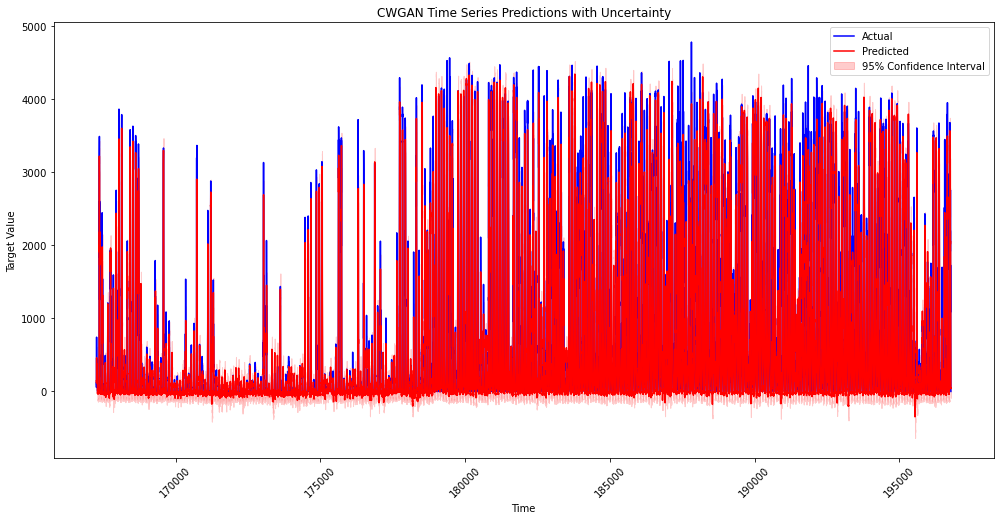


Probabilistic Metrics:
Coverage (95% interval): 0.7848
Sharpness (mean 95% interval width): 244.7415


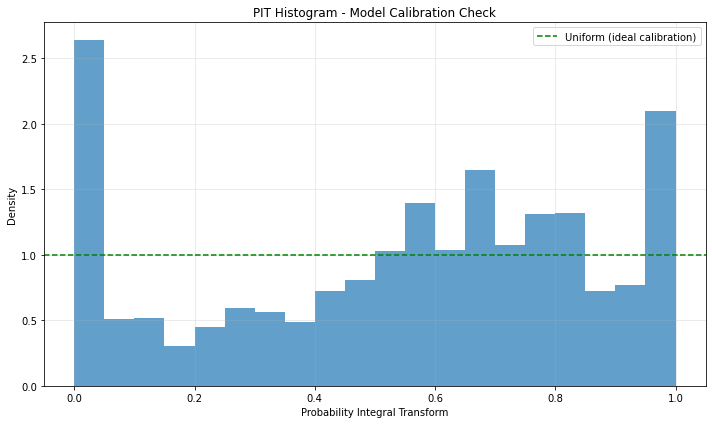

In [8]:
class WGAN_GP:
    def __init__(self, input_dim, latent_dim=100, gp_weight=10.0):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.gp_weight = gp_weight

        # Build models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # REDUCED learning rates for better stability
        self.generator_optimizer = keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9)
        self.discriminator_optimizer = keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9)


    def build_generator(self):
        # Same architecture as before
        noise_input = keras.Input(shape=(self.latent_dim,))
        cond_input = keras.Input(shape=(self.input_dim,))

        # Process conditional input
        c = layers.Dense(64)(cond_input)
        c = layers.LeakyReLU(0.2)(c)
        c = layers.BatchNormalization()(c)

        # Process noise
        z = layers.Dense(64)(noise_input)
        z = layers.LeakyReLU(0.2)(z)
        z = layers.BatchNormalization()(z)

        # Merge inputs
        merged = layers.Concatenate()([z, c])

        # Generator network with residual connections
        x = layers.Dense(128)(merged)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)

        # Residual block 1
        res = x
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, res])

        x = layers.Dense(64)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.BatchNormalization()(x)

        # Output layer - prediction
        output = layers.Dense(1, activation='linear')(x)

        model = keras.Model([noise_input, cond_input], output, name="generator")
        return model

    def build_discriminator(self):
        # Same architecture as before
        energy_input = keras.Input(shape=(1,))
        cond_input = keras.Input(shape=(self.input_dim,))

        # Process conditional input
        c = layers.Dense(64)(cond_input)
        c = layers.LeakyReLU(0.2)(c)

        # Process energy value
        e = layers.Dense(32)(energy_input)
        e = layers.LeakyReLU(0.2)(e)

        # Merge inputs
        merged = layers.Concatenate()([e, c])

        x = layers.Dense(128)(merged)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Dropout(0.3)(x)

        # No sigmoid for Wasserstein - output raw score
        validity = layers.Dense(1)(x)

        model = keras.Model([energy_input, cond_input], validity, name="discriminator")
        return model

    def gradient_penalty(self, real_samples, fake_samples, cond_input):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform(shape=[batch_size, 1], minval=0.0, maxval=1.0)
        interpolates = alpha * real_samples + (1 - alpha) * fake_samples

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolates)
            pred = self.discriminator([interpolates, cond_input])
        grads = gp_tape.gradient(pred, interpolates)

        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        # Return gradient penalty
        return tf.reduce_mean((grad_norm - 1.0) ** 2)

    @tf.function
    def train_step_discriminator(self, real_energy, real_conditions):
        batch_size = tf.shape(real_energy)[0]

        # Generate random noise
        noise = tf.random.normal([batch_size, self.latent_dim])

        # Generate fake energy predictions
        fake_energy = self.generator([noise, real_conditions])

        with tf.GradientTape() as disc_tape:
            # Get critic scores
            real_output = self.discriminator([real_energy, real_conditions])
            fake_output = self.discriminator([fake_energy, real_conditions])

            # Calculate discriminator loss (wasserstein)
            disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

            # Calculate gradient penalty - REDUCED weight for stability
            gp = self.gradient_penalty(real_energy, fake_energy, real_conditions)
            
            # Reduced gradient penalty weight for better stability
            disc_loss += self.gp_weight * gp

        # Get gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        
        # ADDED: Clip gradients to prevent exploding gradients
        disc_gradients, _ = tf.clip_by_global_norm(disc_gradients, 1.0)

        # Apply gradients
        self.discriminator_optimizer.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables)
        )

        return disc_loss

    @tf.function
    def train_step_generator(self, real_conditions):
        batch_size = tf.shape(real_conditions)[0]

        # Generate random noise
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape:
            # Generate fake energy predictions
            fake_energy = self.generator([noise, real_conditions])

            # Get critic score on fake data
            fake_output = self.discriminator([fake_energy, real_conditions])

            # Calculate generator loss
            gen_loss = -tf.reduce_mean(fake_output)

        # Get gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        
        # ADDED: Clip gradients to prevent exploding gradients
        gen_gradients, _ = tf.clip_by_global_norm(gen_gradients, 1.0)

        # Apply gradients
        self.generator_optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables)
        )

        return gen_loss

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=64, n_critic=5, patience=20):
        # Convert inputs to tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    
        # Handle pandas Series if needed
        if hasattr(y_train, 'values'):
            y_train_numpy = y_train.values
        else:
            y_train_numpy = y_train
        
        y_train = tf.convert_to_tensor(y_train_numpy.reshape(-1, 1), dtype=tf.float32)

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((y_train, X_train))
        dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

        # For validation
        val_available = X_val is not None and y_val is not None
        
        if val_available:
            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            if hasattr(y_val, 'values'):
                y_val_numpy = y_val.values
            else:
                y_val_numpy = y_val
            y_val = tf.convert_to_tensor(y_val_numpy.reshape(-1, 1), dtype=tf.float32)

        d_losses = []
        g_losses = []
        val_losses = []
        
        # Early stopping variables
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement = 0
        best_weights_generator = None
        best_weights_discriminator = None

        for epoch in range(epochs):
            d_loss_epoch = []
            g_loss_epoch = []

            for batch_idx, (real_energy, real_conditions) in enumerate(dataset):
                # Train discriminator multiple times
                for _ in range(n_critic):
                    d_loss = self.train_step_discriminator(real_energy, real_conditions)
                    d_loss_epoch.append(d_loss)

                # Train generator once
                g_loss = self.train_step_generator(real_conditions)
                g_loss_epoch.append(g_loss)

            # Average losses - use abs() to prevent negative loss values causing confusion
            avg_d_loss = tf.abs(tf.reduce_mean(d_loss_epoch))
            avg_g_loss = tf.abs(tf.reduce_mean(g_loss_epoch))

            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)

            # Validation
            if val_available:
                # FIXED: Unpack three values instead of two
                y_val_pred, _, _ = self.predict(X_val, num_samples=10)
                val_mse = tf.reduce_mean(tf.square(y_val.numpy().flatten() - y_val_pred))
                val_losses.append(val_mse)
            
                # Early stopping logic
                if val_mse < best_val_loss:
                    best_val_loss = val_mse
                    best_epoch = epoch
                    no_improvement = 0
                    # Save best weights
                    best_weights_generator = self.generator.get_weights()
                    best_weights_discriminator = self.discriminator.get_weights()
                else:
                    no_improvement += 1
                
                if epoch % 5 == 0:
                    print(f"Epoch {epoch}/{epochs} [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}] [Val MSE: {val_mse:.4f}]")
                
                # Check if early stopping criteria is met
                if no_improvement >= patience:
                    print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch} with validation MSE {best_val_loss:.4f}")
                    # Restore best weights
                    self.generator.set_weights(best_weights_generator)
                    self.discriminator.set_weights(best_weights_discriminator)
                    break
            elif epoch % 5 == 0:
                print(f"Epoch {epoch}/{epochs} [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")

        # Plot training curves
        plt.figure(figsize=(10, 6))
        plt.plot(d_losses, label='Critic Loss')
        plt.plot(g_losses, label='Generator Loss')
        if val_available and len(val_losses) > 0:
            # Create a new x-axis for val_losses (since they're only computed every epoch)
            val_epochs = np.arange(len(val_losses))
            plt.plot(val_epochs, val_losses, label='Validation MSE')
            plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_epoch})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('CWGAN Training History')
        plt.tight_layout()
        plt.show()

        return d_losses, g_losses, val_losses if val_available else None

    def predict(self, X_test, num_samples=100000):
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        batch_size = X_test.shape[0]
    
        all_predictions = []
    
        # Generate multiple predictions for each test point
        for _ in range(num_samples):
            noise = tf.random.normal([batch_size, self.latent_dim])
            predictions = self.generator([noise, X_test]).numpy().flatten()
            all_predictions.append(predictions)
        
        all_predictions = np.array(all_predictions)
    
        # Calculate mean and standard deviation for uncertainty
        mean_predictions = np.mean(all_predictions, axis=0)
        std_predictions = np.std(all_predictions, axis=0)
    
        return mean_predictions, std_predictions, all_predictions
def main():
    target_col = 'Energy delta[Wh]' 
    feature_cols = [col for col in train_data.columns if col != target_col and col != 'Time']
    
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    
    X_val = validation_data[feature_cols]
    y_val = validation_data[target_col]
    
    X_test = test_data[feature_cols]
    y_test = test_data[target_col]
    
    # Print data information for debugging
    print("Training data shape:", X_train.shape, y_train.shape)
    print("Validation data shape:", X_val.shape, y_val.shape)
    print("Test data shape:", X_test.shape, y_test.shape)
    print("Target value range:", y_train.min(), "-", y_train.max())
    print("Target value mean and std:", y_train.mean(), y_train.std())
    
    # Scale the data
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train).astype(np.float32)
    X_val_scaled = X_scaler.transform(X_val).astype(np.float32)
    X_test_scaled = X_scaler.transform(X_test).astype(np.float32)
    
    y_scaler = StandardScaler()
    # Handle pandas Series properly
    if isinstance(y_train, pd.Series):
        y_train_numpy = y_train.values
        y_val_numpy = y_val.values
        y_test_numpy = y_test.values
    else:
        y_train_numpy = y_train
        y_val_numpy = y_val
        y_test_numpy = y_test
    
    y_train_scaled = y_scaler.fit_transform(y_train_numpy.reshape(-1, 1)).flatten().astype(np.float32)
    y_val_scaled = y_scaler.transform(y_val_numpy.reshape(-1, 1)).flatten().astype(np.float32)
    y_test_scaled = y_scaler.transform(y_test_numpy.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Print scaling information for debugging
    print("Y scaler mean:", y_scaler.mean_)
    print("Y scaler scale:", y_scaler.scale_)
    
    print("Initializing CWGAN model...")
    wgan = WGAN_GP(input_dim=X_train_scaled.shape[1], latent_dim=50, gp_weight=5.0)
    
    print("Training CWGAN model with validation...")
    epochs = 100
    batch_size = 64
    n_critic = 5
    patience = 15  # Early stopping patience
    
    d_losses, g_losses, val_losses = wgan.train(
        X_train_scaled, y_train_scaled,
        X_val=X_val_scaled, y_val=y_val_scaled,
        epochs=epochs, batch_size=batch_size, n_critic=n_critic,
        patience=patience
    )
    
    print("Generating predictions...")
    y_pred_mean, y_pred_std, y_pred_samples = wgan.predict(X_test_scaled, num_samples=100)
    y_pred_mean_scaled = y_pred_mean.copy()
    y_pred_std_scaled = y_pred_std.copy()
    y_pred_samples_scaled = y_pred_samples.copy() 
    y_pred_mean = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).flatten()
    
    # Handle scalar or array for scale_
    if hasattr(y_scaler, 'scale_') and hasattr(y_scaler.scale_, '__getitem__'):
        y_pred_std = y_pred_std * y_scaler.scale_[0]  # Scale the standard deviation
    else:
        y_pred_std = y_pred_std * y_scaler.scale_  # If scale_ is a scalar
    
    # New: Inverse transform all prediction samples
    y_pred_samples_original = np.empty_like(y_pred_samples)
    for i in range(y_pred_samples.shape[0]):
        y_pred_samples_original[i] = y_scaler.inverse_transform(y_pred_samples[i].reshape(-1, 1)).flatten()
    
    # Evaluate model on BOTH scaled and original data for comparison
    #print("Metrics on ORIGINAL scale:")
    #metrics_orig = evaluate_model(y_test, y_pred_mean, "WGAN-GP (Time-based Split - Original Scale)")
    
    print("\nMetrics on SCALED data:")
    metrics_scaled = evaluate_model(y_test_scaled, y_pred_mean_scaled, "CWGAN (Time-based Split - Scaled)")
    
    # Plot predictions vs actual in the original scale
    plt.figure(figsize=(12, 6))
    
    # Sort indices for better visualization
    y_test_np = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    y_pred_mean_np = np.array(y_pred_mean)
    y_pred_std_np = np.array(y_pred_std)

    # Then sort
    sort_idx = np.argsort(y_test_np)
    y_test_sorted = y_test_np[sort_idx]
    y_pred_sorted = y_pred_mean_np[sort_idx]
    y_std_sorted = y_pred_std_np[sort_idx]
    
    plt.plot(y_test_sorted, 'b-', label='Actual')
    plt.plot(y_pred_sorted, 'r-', label='Predicted')
    
    # Plot uncertainty bands (±2 std dev)
    plt.fill_between(
        range(len(y_pred_sorted)),
        y_pred_sorted - 2 * y_std_sorted,
        y_pred_sorted + 2 * y_std_sorted,
        color='r',
        alpha=0.2,
        label='95% Confidence Interval'
    )
    
    plt.xlabel('Test Sample Index (sorted)')
    plt.ylabel('Target Value')
    plt.title('CWGAN Predictions with Uncertainty (Time-based Split)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot histogram of errors
    plt.figure(figsize=(10, 6))
    errors = y_test - y_pred_mean
    plt.hist(errors, bins=50, alpha=0.75)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors (Time-based Split)')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Additional: Plot time-based prediction vs actual
    plt.figure(figsize=(14, 7))
    
    # Assuming the index is time-based
    if hasattr(test_data, 'index'):
        time_index = test_data.index
        plt.plot(time_index, y_test, 'b-', label='Actual')
        plt.plot(time_index, y_pred_mean, 'r-', label='Predicted')
        
        # Plot uncertainty bands (±2 std dev)
        plt.fill_between(
            time_index,
            y_pred_mean - 2 * y_pred_std,
            y_pred_mean + 2 * y_pred_std,
            color='r',
            alpha=0.2,
            label='95% Confidence Interval'
        )
        
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.title('CWGAN Time Series Predictions with Uncertainty')
        plt.legend()
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()
    
    def calculate_probabilistic_metrics(y_true, y_pred_samples):
        lower_95 = np.percentile(y_pred_samples, 2.5, axis=0)
        upper_95 = np.percentile(y_pred_samples, 97.5, axis=0)
        coverage_95 = np.mean((y_true >= lower_95) & (y_true <= upper_95))
        
        # Calculate sharpness (mean width of prediction intervals)
        sharpness_95 = np.mean(upper_95 - lower_95)
        
        # Calculate PIT (Probability Integral Transform) values
        pit_values = []
        for i in range(len(y_true)):
            # Calculate empirical CDF at the true value
            pit = np.mean(y_pred_samples[:, i] <= y_true[i])
            pit_values.append(pit)
        
        # Print metrics
        print("\nProbabilistic Metrics:")
        print(f"Coverage (95% interval): {coverage_95:.4f}")
        print(f"Sharpness (mean 95% interval width): {sharpness_95:.4f}")
        
        # Plot PIT histogram (should be uniform for well-calibrated forecasts)
        plt.figure(figsize=(10, 6))
        plt.hist(pit_values, bins=20, density=True, alpha=0.7)
        plt.axhline(y=1.0, color='g', linestyle='--', label='Uniform (ideal calibration)')
        plt.xlabel('Probability Integral Transform')
        plt.ylabel('Density')
        plt.title('PIT Histogram - Model Calibration Check')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return {
            'coverage_95': coverage_95,
            'sharpness_95': sharpness_95,
            'pit_values': pit_values
        }
    
    # Calculate probabilistic metrics
    prob_metrics = calculate_probabilistic_metrics(
        y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred_samples_original
    )
    

    return wgan, metrics_scaled, {
        'y_pred_mean': y_pred_mean,
        'y_pred_std': y_pred_std,
        'y_pred_samples': y_pred_samples_original,
        'y_true': y_test.values if hasattr(y_test, 'values') else y_test,
        'prob_metrics': prob_metrics,
        'X_test_scaled': X_test_scaled,
        'y_test_scaled': y_test_scaled 


    }




if __name__ == "__main__":
    set_seeds(42)
    wgan, metrics, results = main()
    

### MORE INSIGHTS AND VISUALIZATION FOR OUR CWGAN MODEL

Training data shape: (137727, 18) (137727,)
Validation data shape: (29512, 18) (29512,)
Test data shape: (29514, 18) (29514,)
Target value range: 0 - 4913
Target value mean and std: 569.809979161675 1048.7740820078607
Y scaler mean: [569.80997916]
Y scaler scale: [1048.77027456]
Initializing CWGAN model...
Training CWGAN model with validation...
Epoch 0/100 [D loss: 0.6739] [G loss: 8.4202] [Val MSE: 0.0811]
Epoch 5/100 [D loss: 0.0899] [G loss: 2.9089] [Val MSE: 0.0712]
Epoch 10/100 [D loss: 0.1360] [G loss: 6.5043] [Val MSE: 0.1213]
Epoch 15/100 [D loss: 0.0674] [G loss: 14.9072] [Val MSE: 0.0712]
Early stopping at epoch 16. Best epoch was 1 with validation MSE 0.0708


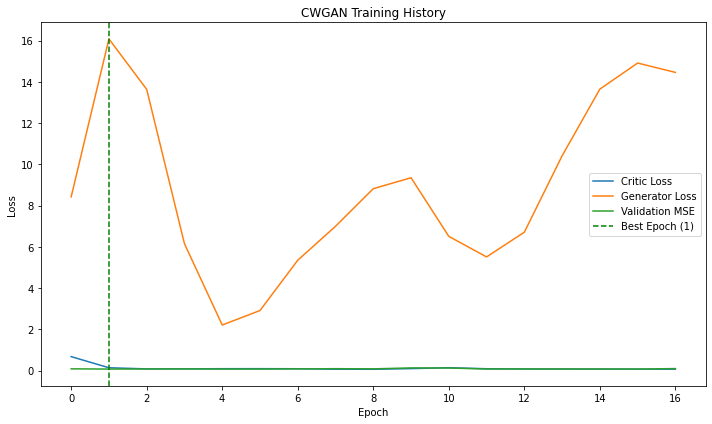

Generating predictions...

Metrics on SCALED data:
CWGAN (Time-based Split - Scaled) Performance:
MSE: 0.0676
RMSE: 0.2601
MAE: 0.1200
R²: 0.9322
----------------------------------------


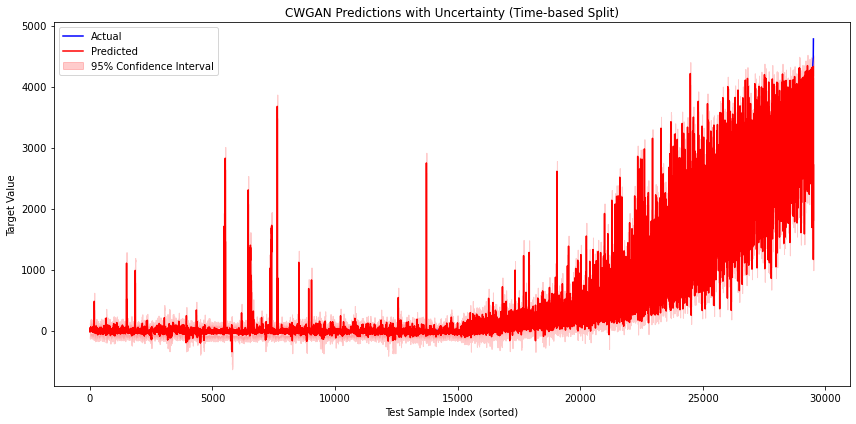

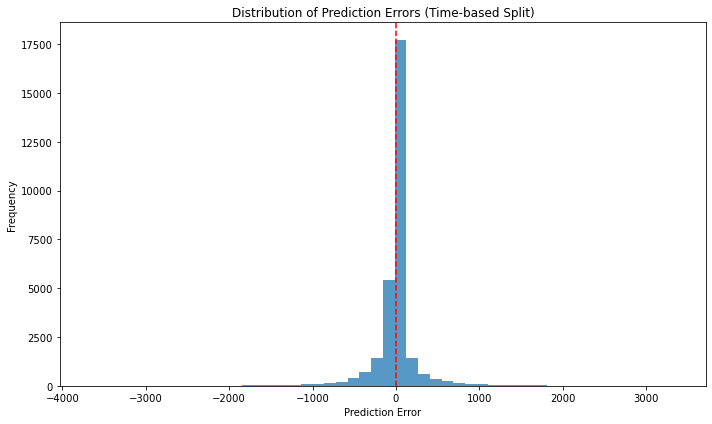

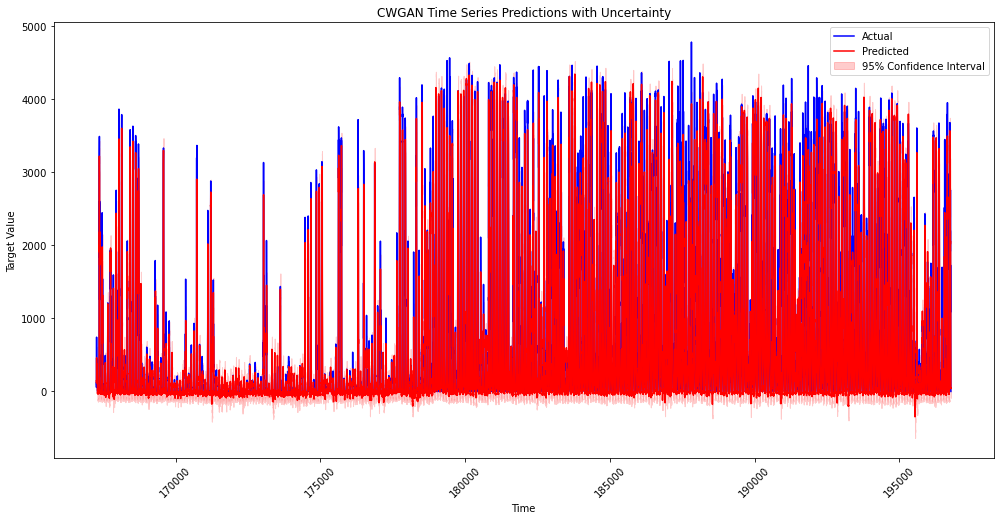


Probabilistic Metrics:
Coverage (95% interval): 0.7848
Sharpness (mean 95% interval width): 244.7415


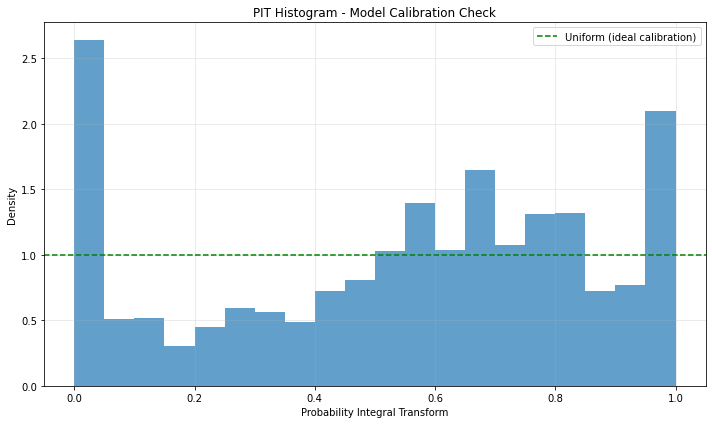


CWGAN Model Evaluation: Real vs Generated Analysis


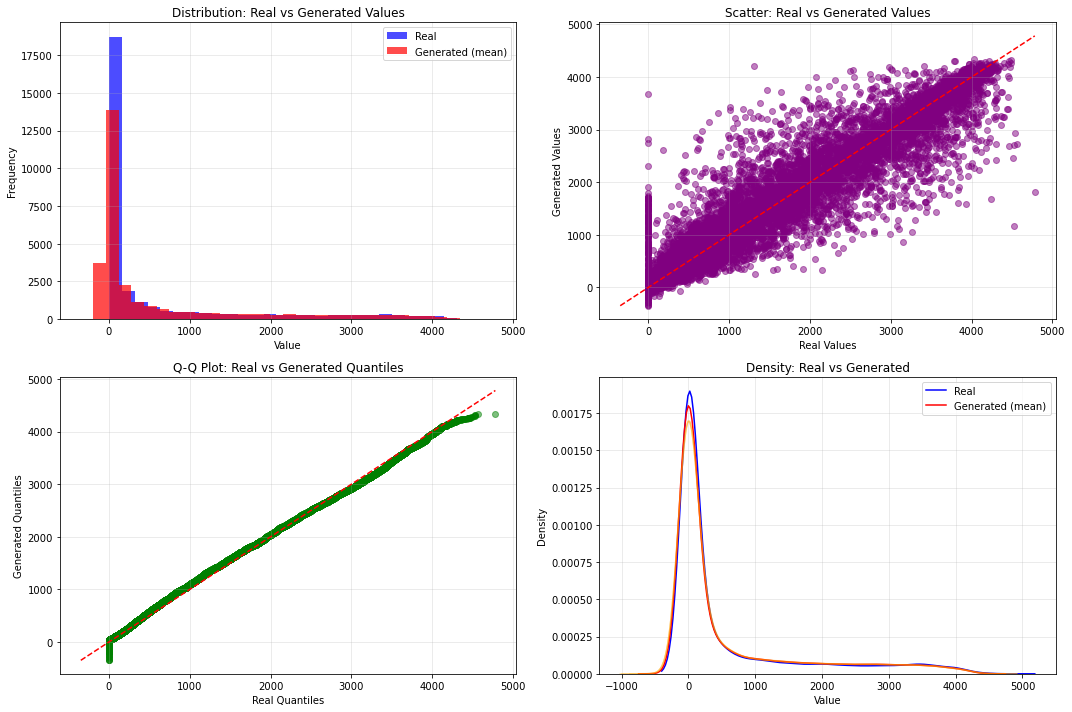

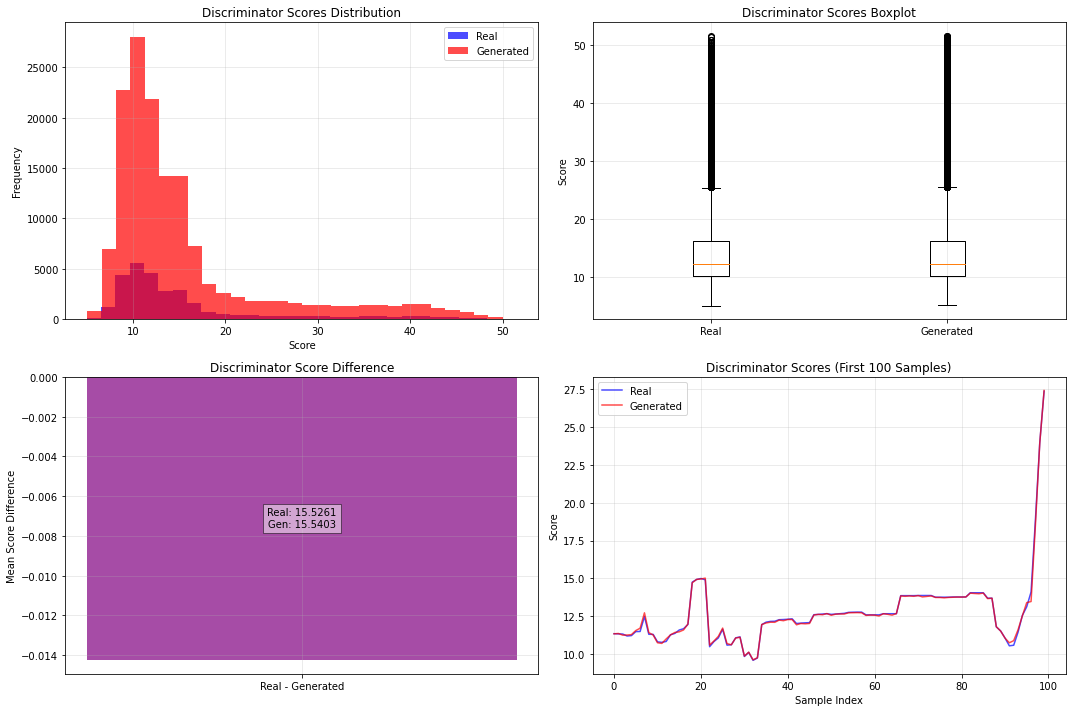

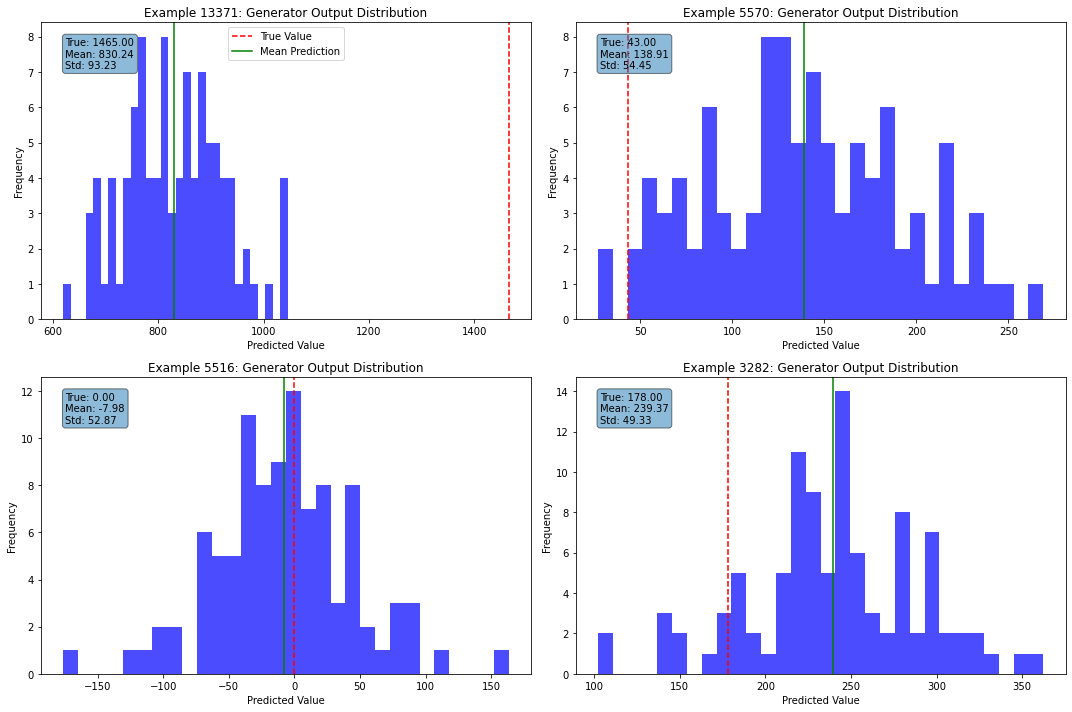

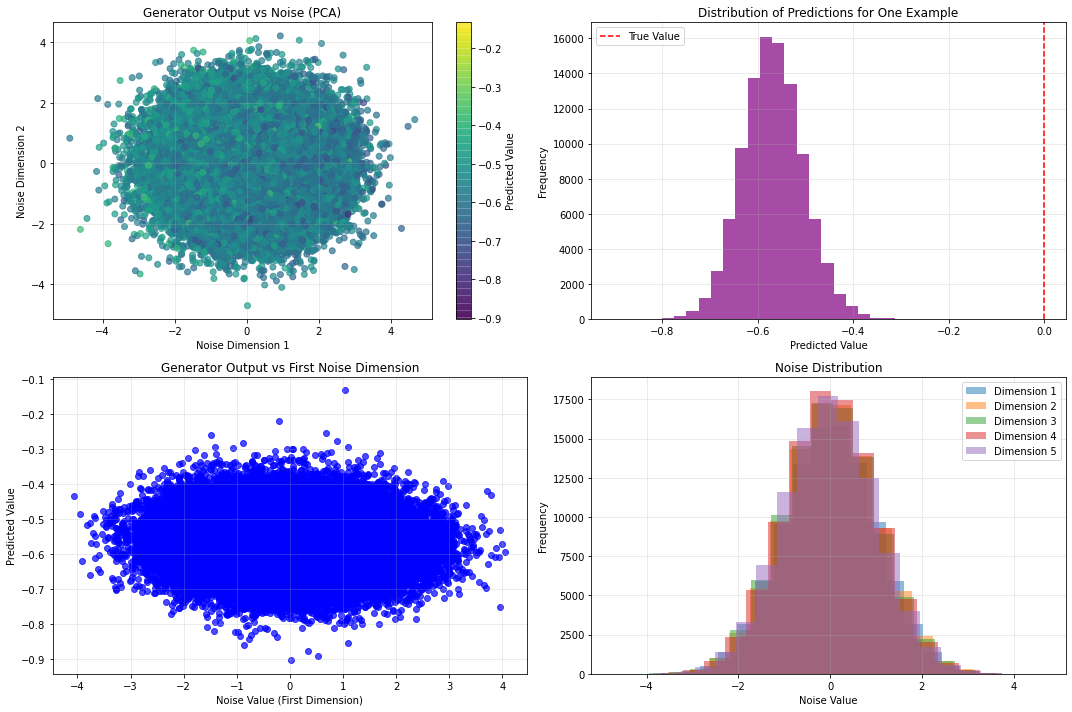

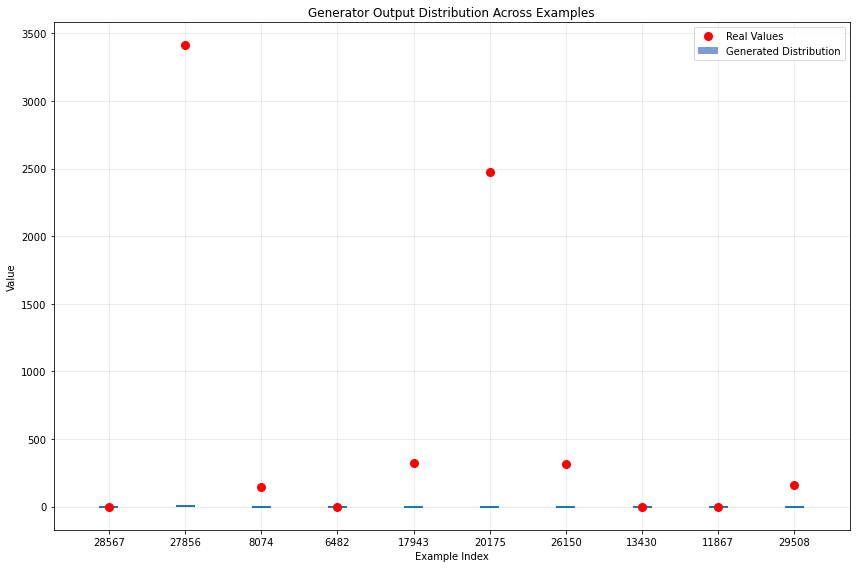

In [9]:
if __name__ == "__main__":
    set_seeds(42)
    wgan, metrics, results = main()
    
    # Comprehensive evaluation of WGAN-GP model
    print("\n" + "="*80)
    print("CWGAN Model Evaluation: Real vs Generated Analysis")
    print("="*80)
    
    # Get necessary data from results dictionary
    X_test_tensor = tf.convert_to_tensor(results['X_test_scaled'], dtype=tf.float32)
    y_test_np = results['y_true']
    y_pred_mean = results['y_pred_mean']
    y_pred_std = results['y_pred_std']
    y_pred_samples = results['y_pred_samples']
    y_test_scaled = results['y_test_scaled']  # Need to include this in results
    
    # Convert to numpy arrays for processing
    y_pred_mean_np = np.array(y_pred_mean)
    y_pred_std_np = np.array(y_pred_std)

    # Then sort
    sort_idx = np.argsort(y_test_np)
    y_test_sorted = y_test_np[sort_idx]
    y_pred_sorted = y_pred_mean_np[sort_idx]
    y_std_sorted = y_pred_std_np[sort_idx]
    
    # 1. REAL VS GENERATED DATA COMPARISON
    plt.figure(figsize=(15, 10))
    
    # Histogram comparison
    plt.subplot(2, 2, 1)
    plt.hist(y_test_np, bins=30, alpha=0.7, label='Real', color='blue')
    plt.hist(y_pred_mean, bins=30, alpha=0.7, label='Generated (mean)', color='red')
    plt.title('Distribution: Real vs Generated Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Scatter plot
    plt.subplot(2, 2, 2)
    plt.scatter(y_test_np, y_pred_mean, alpha=0.5, color='purple')
    min_val = min(y_test_np.min(), y_pred_mean.min())
    max_val = max(y_test_np.max(), y_pred_mean.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Scatter: Real vs Generated Values')
    plt.xlabel('Real Values')
    plt.ylabel('Generated Values')
    plt.grid(True, alpha=0.3)
    
    # Q-Q plot
    plt.subplot(2, 2, 3)
    real_sorted = np.sort(y_test_np)
    gen_sorted = np.sort(y_pred_mean)
    plt.scatter(real_sorted, gen_sorted, alpha=0.5, color='green')
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Q-Q Plot: Real vs Generated Quantiles')
    plt.xlabel('Real Quantiles')
    plt.ylabel('Generated Quantiles')
    plt.grid(True, alpha=0.3)
    
    # Density plot
    plt.subplot(2, 2, 4)
    import seaborn as sns
    sns.kdeplot(y_test_np, label='Real', color='blue')
    sns.kdeplot(y_pred_mean, label='Generated (mean)', color='red')
    # Show 3 random sample distributions
    for i in range(min(3, y_pred_samples.shape[0])):
        sns.kdeplot(y_pred_samples[i], alpha=0.3, color='orange', label='_nolegend_')
    plt.title('Density: Real vs Generated')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. DISCRIMINATOR SCORES ANALYSIS
    batch_size = results['X_test_scaled'].shape[0]
    
    # Reshape for discriminator input
    y_test_reshaped = np.reshape(y_test_scaled, (-1, 1))
    
    # Get discriminator scores for real data
    disc_scores_real = wgan.discriminator(
        [tf.convert_to_tensor(y_test_reshaped, dtype=tf.float32), X_test_tensor]
    ).numpy().flatten()
    
    # Generate multiple fake samples and their scores
    disc_scores_fake = []
    for _ in range(5):  # Generate 5 different fake samples
        noise = tf.random.normal([batch_size, wgan.latent_dim])
        fake_samples = wgan.generator([noise, X_test_tensor])
        scores = wgan.discriminator([fake_samples, X_test_tensor]).numpy().flatten()
        disc_scores_fake.append(scores)
    
    # Flatten all fake scores
    all_fake_scores = np.concatenate(disc_scores_fake)
    
    plt.figure(figsize=(15, 10))
    
    # Histogram of discriminator scores
    plt.subplot(2, 2, 1)
    plt.hist(disc_scores_real, bins=30, alpha=0.7, label='Real', color='blue')
    plt.hist(all_fake_scores, bins=30, alpha=0.7, label='Generated', color='red')
    plt.title('Discriminator Scores Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Boxplot comparison
    plt.subplot(2, 2, 2)
    data = [disc_scores_real, all_fake_scores]
    plt.boxplot(data, labels=['Real', 'Generated'])
    plt.title('Discriminator Scores Boxplot')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    
    # Score difference
    plt.subplot(2, 2, 3)
    score_diff = np.mean(disc_scores_real) - np.mean(all_fake_scores)
    plt.bar(['Real - Generated'], [score_diff], color='purple', alpha=0.7)
    plt.title('Discriminator Score Difference')
    plt.ylabel('Mean Score Difference')
    plt.grid(True, alpha=0.3)
    plt.text(0, score_diff/2,
             f'Real: {np.mean(disc_scores_real):.4f}\nGen: {np.mean(all_fake_scores):.4f}',
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    # Time series of scores
    plt.subplot(2, 2, 4)
    plt.plot(disc_scores_real[:100], 'b-', alpha=0.7, label='Real')
    plt.plot(disc_scores_fake[0][:100], 'r-', alpha=0.7, label='Generated')
    plt.title('Discriminator Scores (First 100 Samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. GENERATOR OUTPUT DISTRIBUTION
    plt.figure(figsize=(15, 10))
    
    # Select 4 random examples
    example_indices = np.random.choice(range(len(y_test_np)), size=4, replace=False)
    
    for i, idx in enumerate(example_indices):
        plt.subplot(2, 2, i+1)
        
        # Get all predictions for this example
        example_predictions = y_pred_samples[:, idx]
        true_value = y_test_np[idx]
        
        # Plot histogram
        plt.hist(example_predictions, bins=30, alpha=0.7, color='blue')
        plt.axvline(x=true_value, color='red', linestyle='--', label='True Value')
        plt.axvline(x=np.mean(example_predictions), color='green',
                   linestyle='-', label='Mean Prediction')
        
        # Add information
        plt.title(f'Example {idx}: Generator Output Distribution')
        plt.xlabel('Predicted Value')
        plt.ylabel('Frequency')
        if i == 0:
            plt.legend()
            
        # Add stats in text box
        stats_text = (f'True: {true_value:.2f}\n'
                     f'Mean: {np.mean(example_predictions):.2f}\n'
                     f'Std: {np.std(example_predictions):.2f}')
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                 verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # 4. GENERATOR OUTPUT VS NOISE DIMENSION
    plt.figure(figsize=(15, 10))
    
    # Choose a single test example
    example_idx = np.random.choice(range(len(y_test_np)))
    # FIX: Use results dictionary here too
    example_features = results['X_test_scaled'][example_idx:example_idx+1]
    example_tensor = tf.convert_to_tensor(example_features, dtype=tf.float32)
    true_value = y_test_np[example_idx]
    
    # Generate predictions with varying noise
    num_samples = 100000
    noise_samples = []
    predictions = []
    
    for _ in range(num_samples):
        noise = tf.random.normal([1, wgan.latent_dim])
        noise_samples.append(noise.numpy().flatten())
        pred = wgan.generator([noise, example_tensor]).numpy().flatten()[0]
        predictions.append(pred)
    
    noise_samples = np.array(noise_samples)
    
    # PCA to reduce noise dimensions for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    noise_2d = pca.fit_transform(noise_samples)
    
    # Plot noise vs output
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(noise_2d[:, 0], noise_2d[:, 1], c=predictions,
                         cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Predicted Value')
    plt.title('Generator Output vs Noise (PCA)')
    plt.xlabel('Noise Dimension 1')
    plt.ylabel('Noise Dimension 2')
    plt.grid(True, alpha=0.3)
    
    # Histogram of predictions
    plt.subplot(2, 2, 2)
    plt.hist(predictions, bins=30, alpha=0.7, color='purple')
    plt.axvline(x=true_value, color='red', linestyle='--', label='True Value')
    plt.title('Distribution of Predictions for One Example')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Noise vs prediction scatter
    plt.subplot(2, 2, 3)
    plt.scatter(noise_samples[:, 0], predictions, alpha=0.7, color='blue')
    plt.title('Generator Output vs First Noise Dimension')
    plt.xlabel('Noise Value (First Dimension)')
    plt.ylabel('Predicted Value')
    plt.grid(True, alpha=0.3)
    
    # Noise histogram
    plt.subplot(2, 2, 4)
    for i in range(min(5, wgan.latent_dim)):
        plt.hist(noise_samples[:, i], bins=20, alpha=0.5,
                label=f'Dimension {i+1}')
    plt.title('Noise Distribution')
    plt.xlabel('Noise Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. GENERATOR RESPONSE ACROSS MULTIPLE EXAMPLES
    plt.figure(figsize=(12, 8))
    
    # Select random examples
    sample_indices = np.random.choice(range(len(y_test_np)), size=10, replace=False)
    
    # Generate predictions for each example
    example_predictions = []
    for idx in sample_indices:
        noise = tf.random.normal([20, wgan.latent_dim])  # 20 predictions per example
        # FIX: Use results dictionary here too
        example_X = tf.convert_to_tensor(results['X_test_scaled'][idx:idx+1], dtype=tf.float32)
        example_X = tf.repeat(example_X, 20, axis=0)
        preds = wgan.generator([noise, example_X]).numpy().flatten()
        example_predictions.append(preds)
    
    # Plot as violin plots
    parts = plt.violinplot(example_predictions, showmeans=True)
    
    # Set colors
    for pc in parts['bodies']:
        pc.set_facecolor('#4472C4')
        pc.set_alpha(0.7)
    
    # Add actual values as red dots
    plt.plot(range(1, len(sample_indices)+1), y_test_np[sample_indices], 'ro', ms=8)
    
    plt.title('Generator Output Distribution Across Examples')
    plt.xlabel('Example Index')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, len(sample_indices)+1), sample_indices)
    plt.legend(['Real Values', 'Generated Distribution'])
    
    plt.tight_layout()
    plt.show()
    
    




### Feature Analysis and predictions made by the cwgan model


========= ENERGY CONSUMPTION WGAN-GP MODEL ANALYSIS =========

Extracting model information...
Found input dimension: 18
Found latent dimension: 50

Using 18 features with exact correlations:
  1. lag_1: 0.956000
  2. lag_2: 0.925000
  3. GHI: 0.914619
  4. rolling_mean_24: 0.654000
  5. humidity: -0.544407
  6. isSun: 0.526952
  7. sunlightTime: 0.437296
  8. SunlightTime/daylength: 0.402523
  9. temp: 0.378554
  10. dayLength: 0.280695
  11. clouds_all: -0.190241
  12. weather_type: -0.170046
  13. pressure: 0.115219
  14. hour: -0.080877
  15. rain_1h: -0.059881
  16. snow_1h: -0.050914
  17. month: -0.049307
  18. wind_speed: 0.029385

Creating test data for analysis...

Creating feature importance visualization...


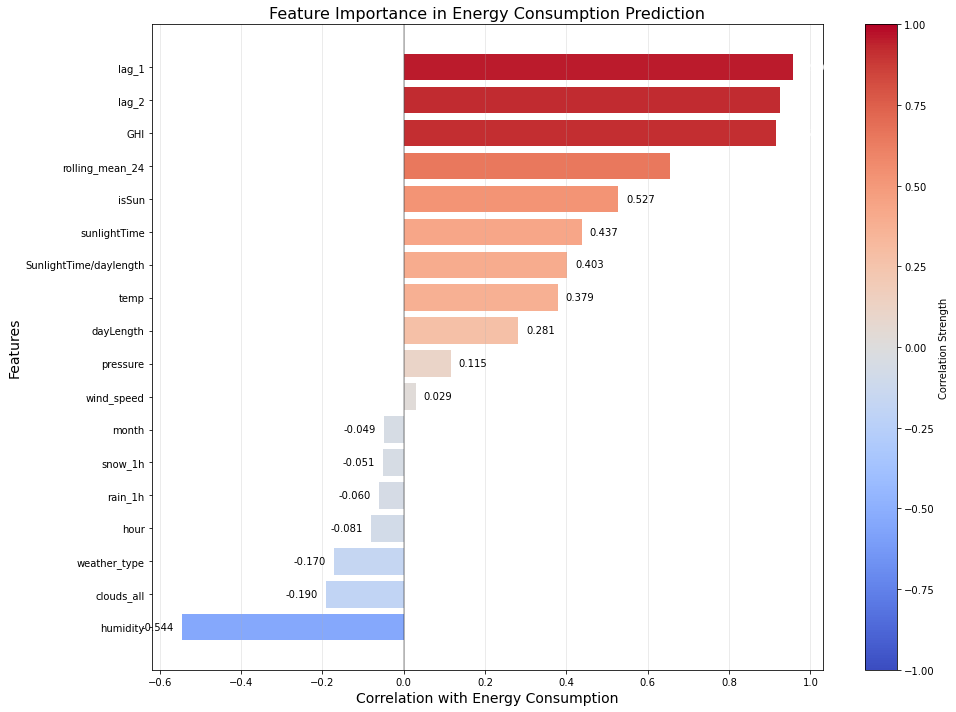


Creating correlation matrix approximation...


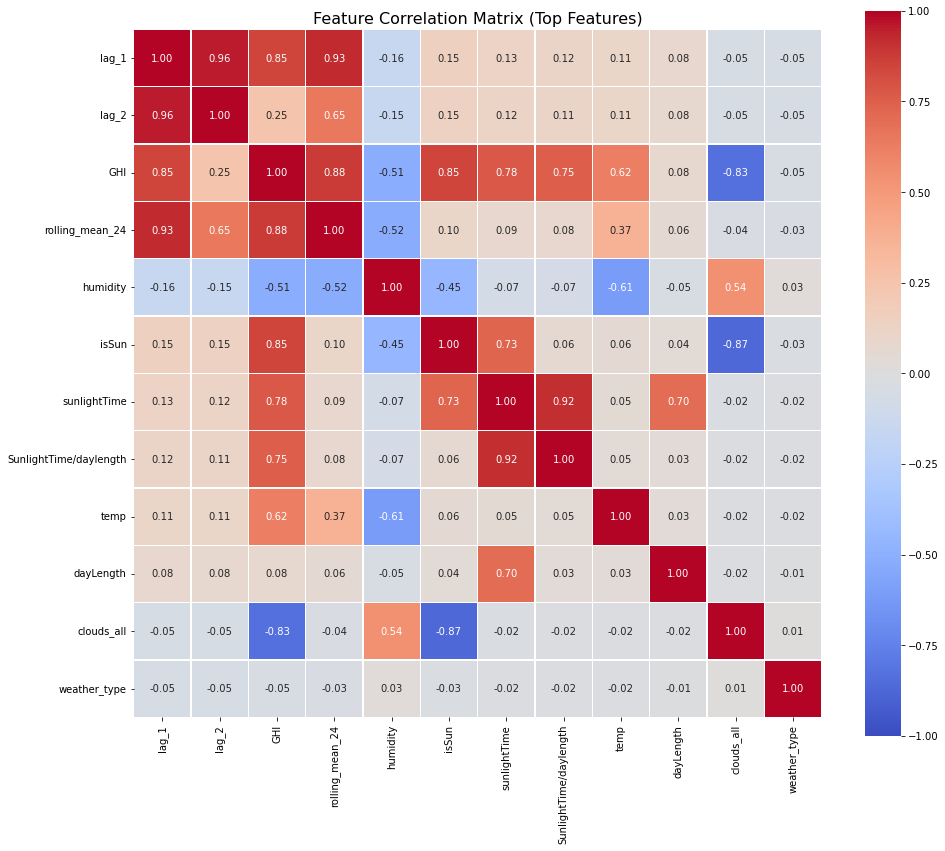


===== FEATURE EFFECTS ANALYSIS =====
Analyzing effects of top 8 features...
Analyzing effect of feature: lag_1 (correlation: 0.9560)


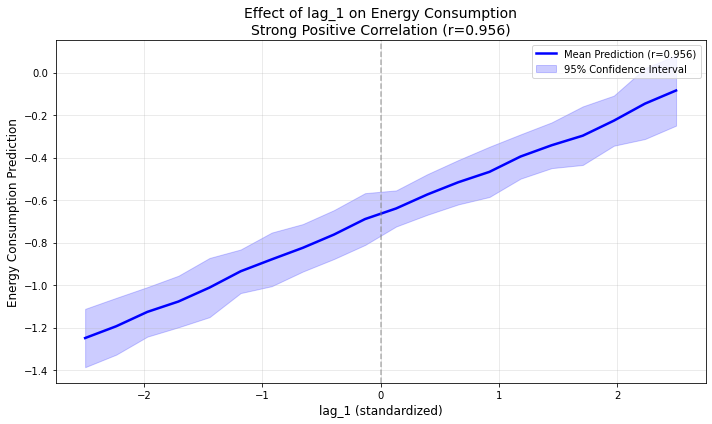

Analyzing effect of feature: lag_2 (correlation: 0.9250)


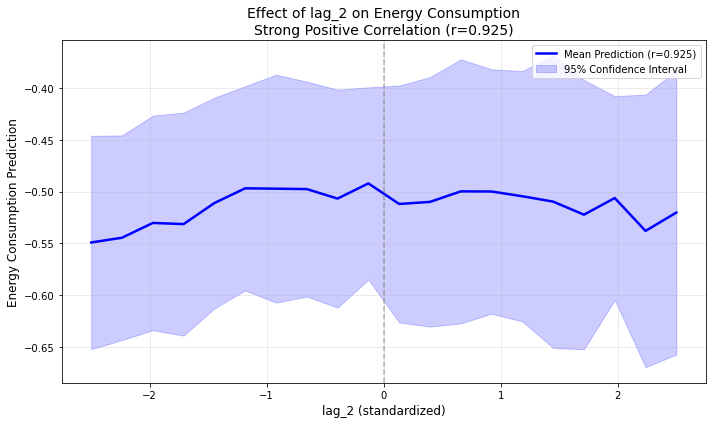

Analyzing effect of feature: GHI (correlation: 0.9146)


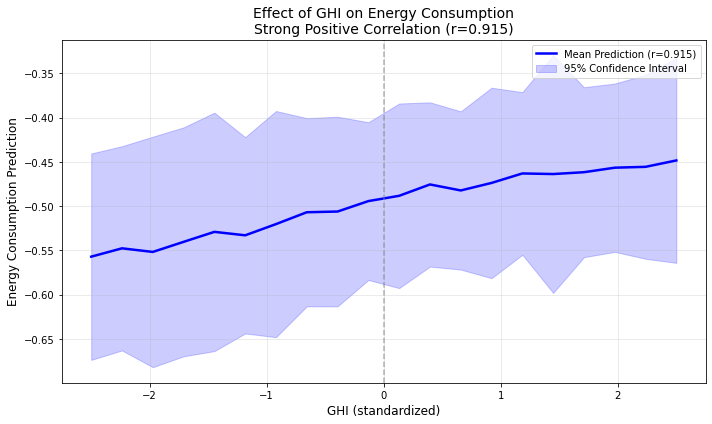

Analyzing effect of feature: rolling_mean_24 (correlation: 0.6540)


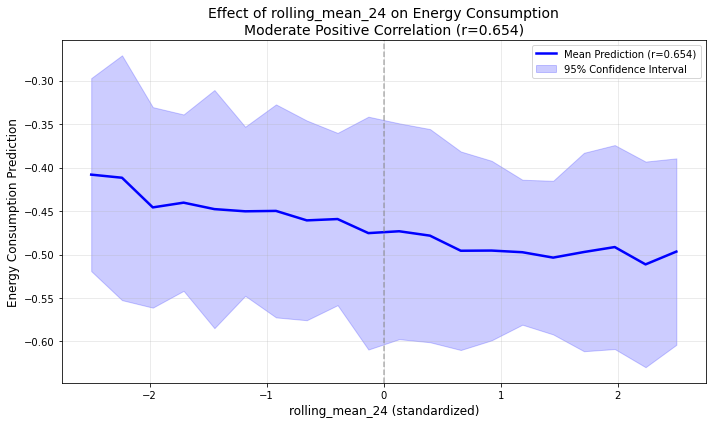

Analyzing effect of feature: humidity (correlation: -0.5444)


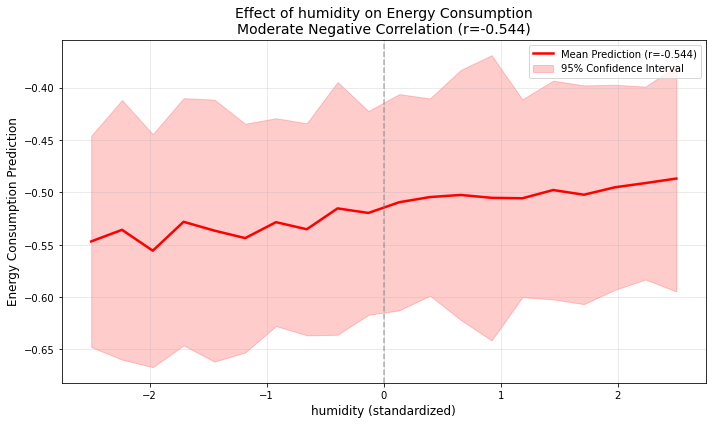

Analyzing effect of feature: isSun (correlation: 0.5270)


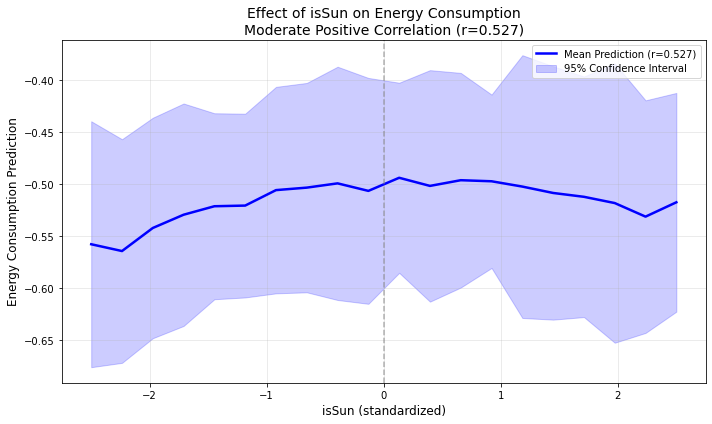

Analyzing effect of feature: sunlightTime (correlation: 0.4373)


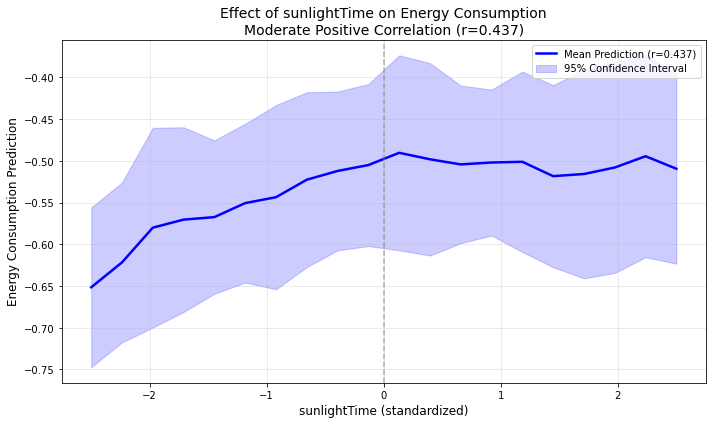

Analyzing effect of feature: SunlightTime/daylength (correlation: 0.4025)
Error analyzing feature SunlightTime/daylength: [Errno 2] No such file or directory: 'energy_model_analysis/feature_effect_SunlightTime/daylength.png'

===== FEATURE INTERACTIONS ANALYSIS =====
Analyzing interaction between rolling_mean_24 and GHI


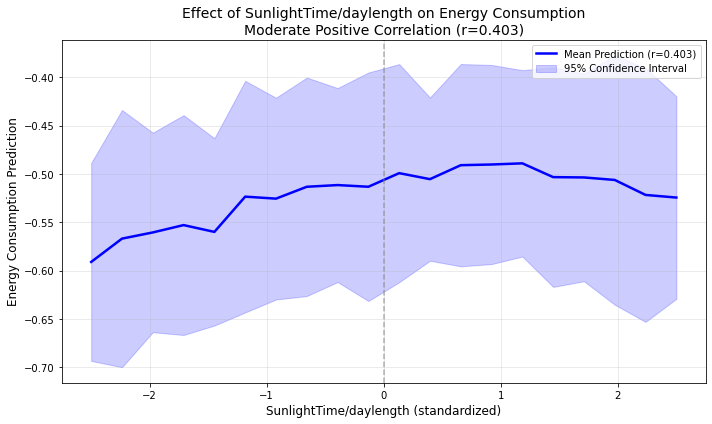

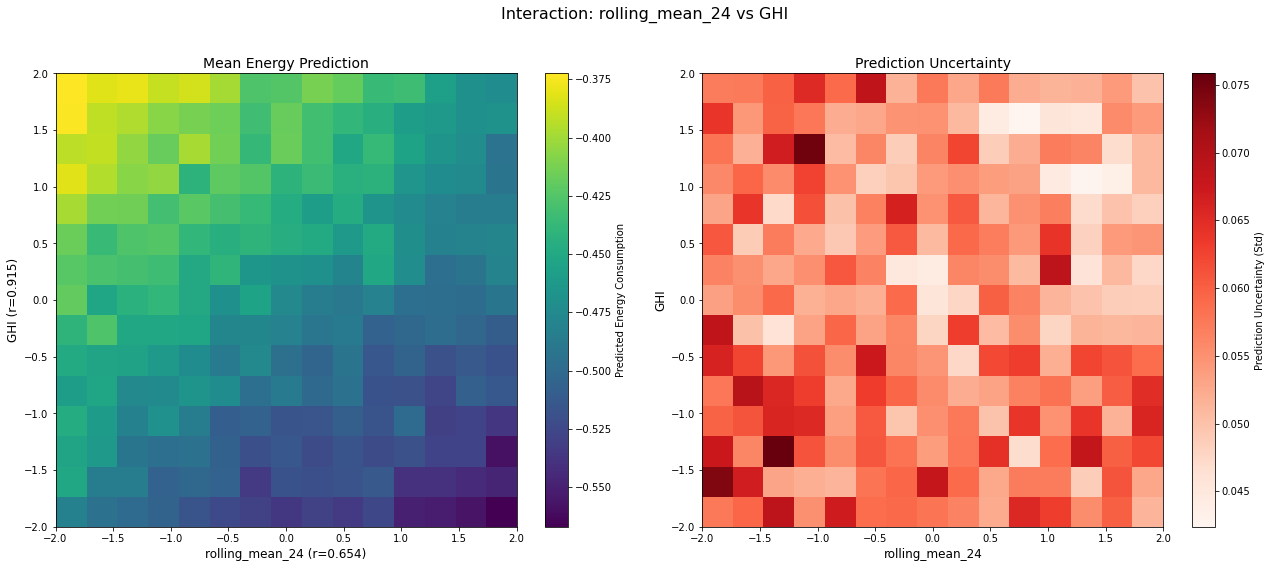

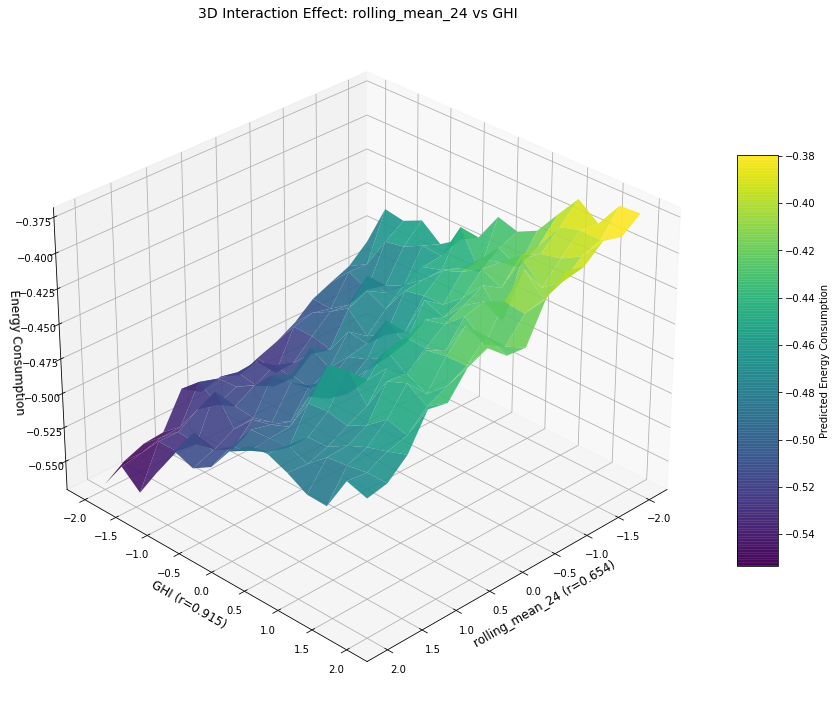

Analyzing interaction between rolling_mean_24 and lag_1


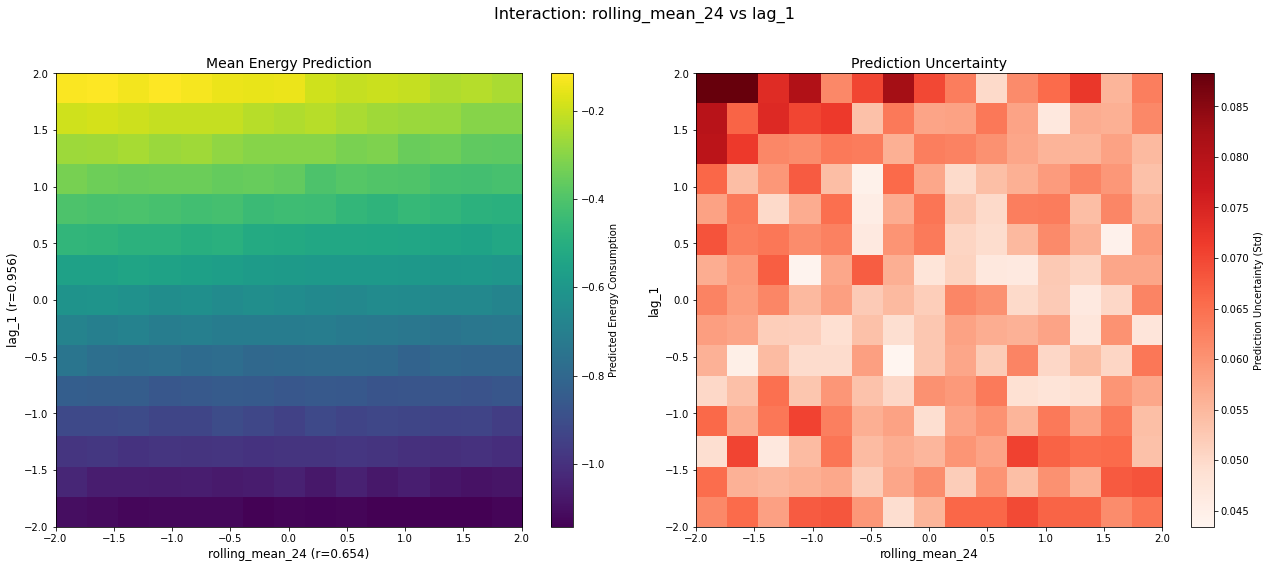

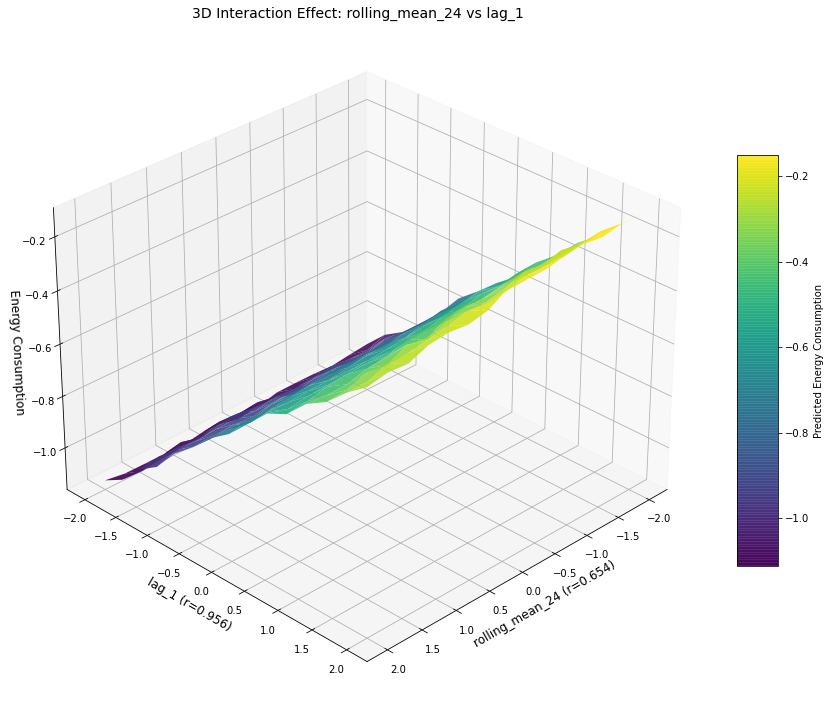

Analyzing interaction between GHI and isSun


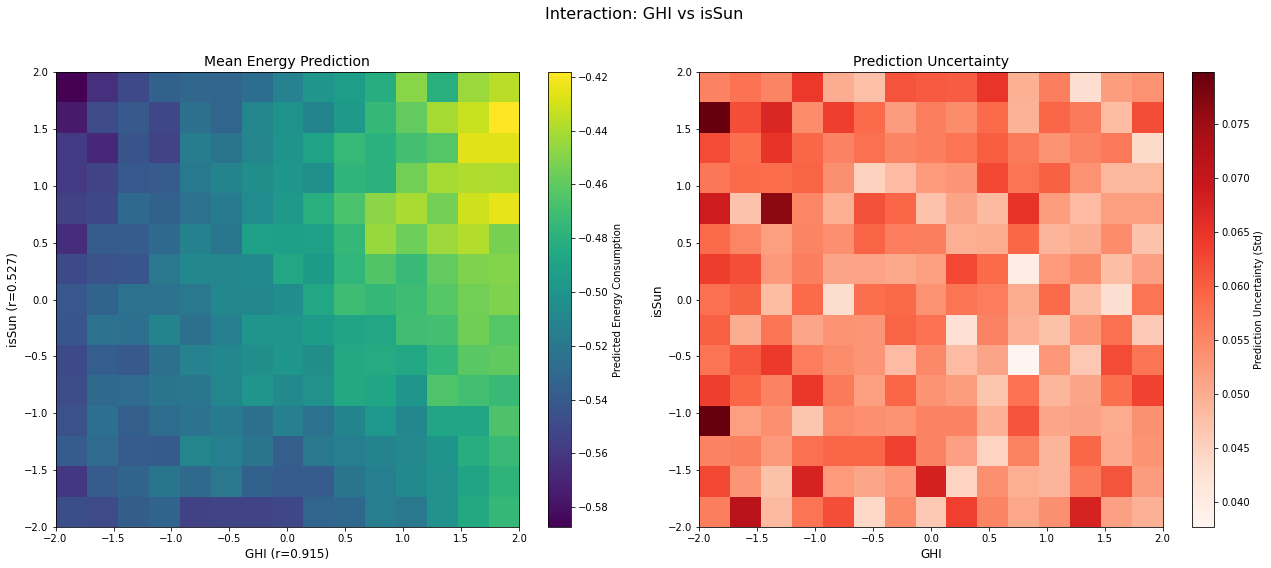

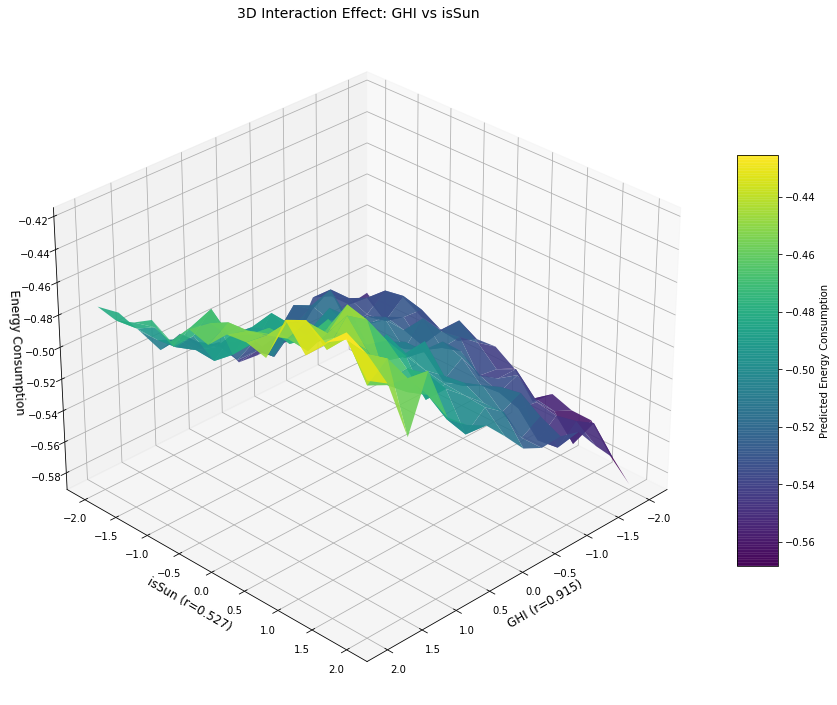

Analyzing interaction between GHI and hour


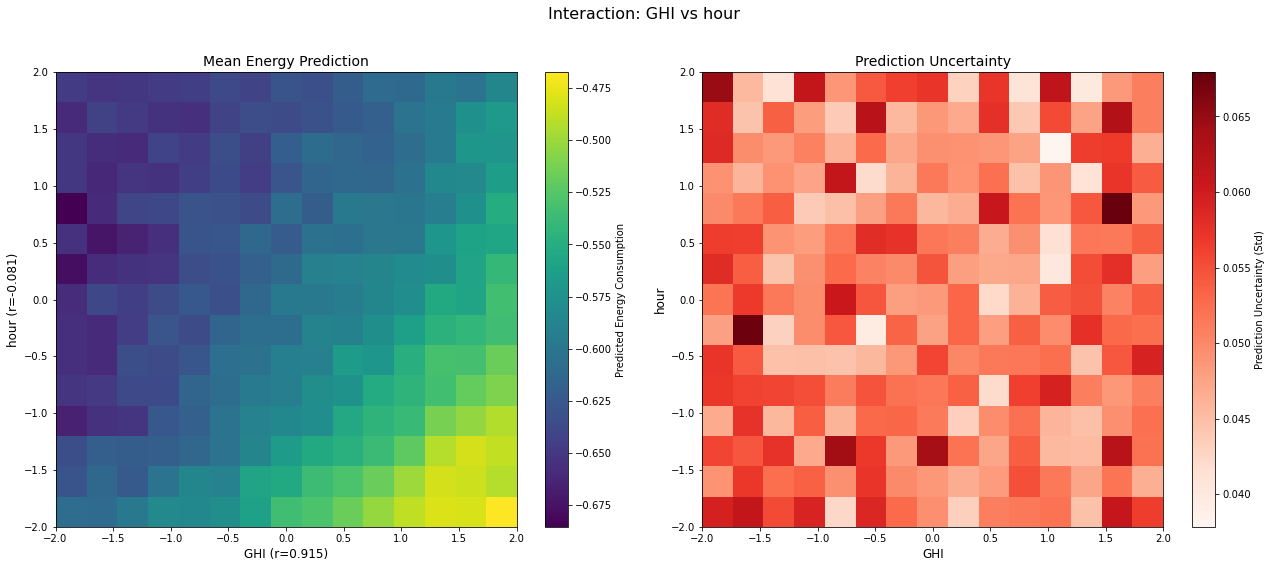

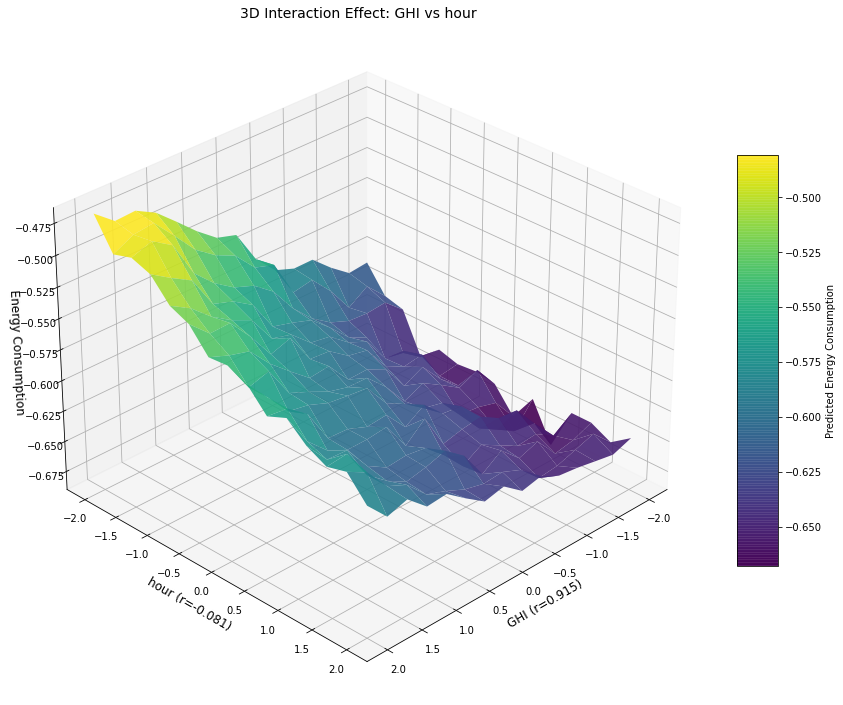


===== TEMPORAL PATTERNS ANALYSIS =====
Analyzing effect of hour (correlation: -0.0809)


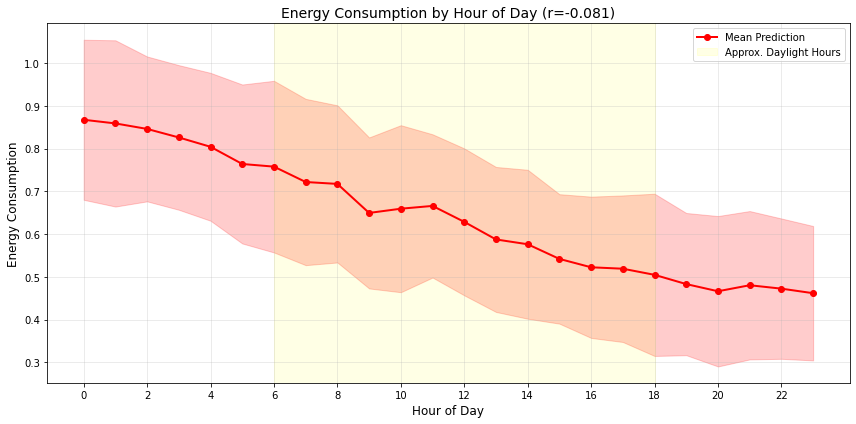

Analyzing effect of month (correlation: -0.0493)


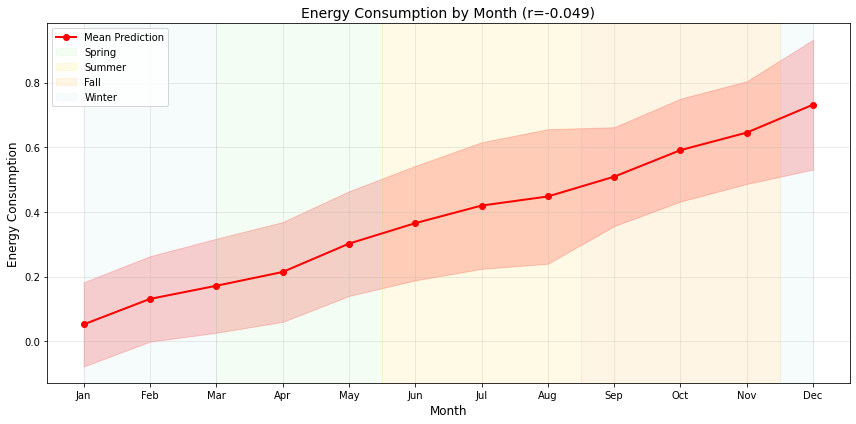


===== CREATING SUMMARY VISUALIZATION =====


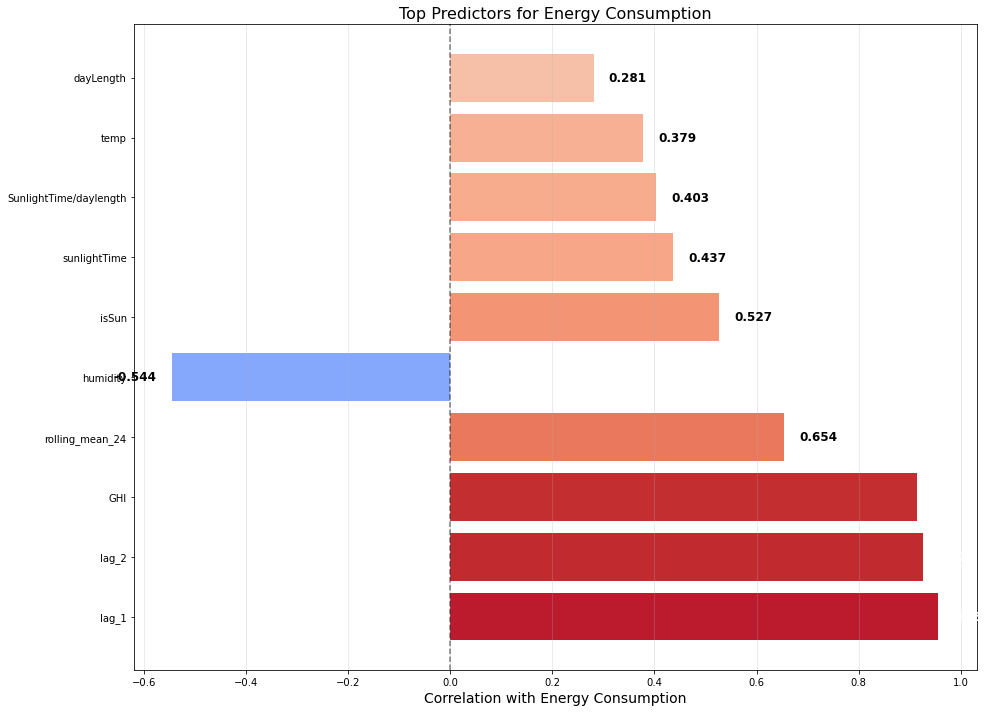

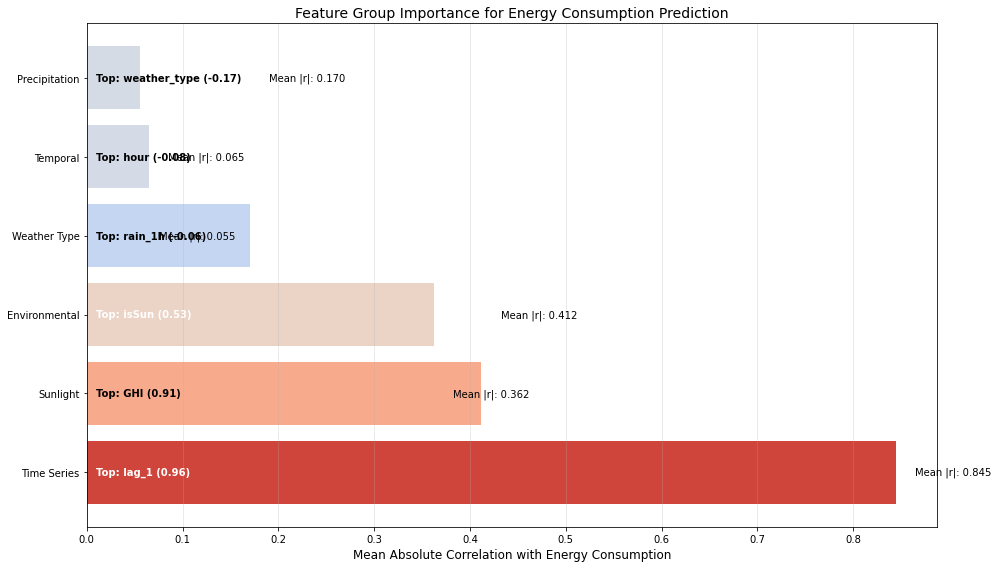


===== KEY INSIGHTS FROM MODEL ANALYSIS =====

Top 5 most important features:
  1. lag_1: 0.9560 (Strong positive correlation)
  2. lag_2: 0.9250 (Strong positive correlation)
  3. GHI: 0.9146 (Strong positive correlation)
  4. rolling_mean_24: 0.6540 (Moderate positive correlation)
  5. humidity: -0.5444 (Moderate negative correlation)

Bottom 3 features (least important):
  18. wind_speed: 0.0294
  17. month: -0.0493
  16. snow_1h: -0.0509


In [10]:
# Import the analysis module
from wgan_energy_output_analysis import analyze_energy_wgan
results = analyze_energy_wgan(wgan) 

In [13]:
feature_importance = results['features']
feature_importance

,Feature,Correlation,Abs_Correlation
0,lag_1,0.956000,0.956000
1,lag_2,0.925000,0.925000
2,GHI,0.914619,0.914619
3,rolling_mean_24,0.654000,0.654000
4,humidity,-0.544407,0.544407
5,isSun,0.526952,0.526952
6,sunlightTime,0.437296,0.437296
7,SunlightTime/daylength,0.402523,0.402523
8,temp,0.378554,0.378554
9,dayLength,0.280695,0.280695


In [54]:
correlation_matrix = results['correlation_matrix']
correlation_matrix

,lag_1,lag_2,GHI,rolling_mean_24,humidity,isSun,sunlightTime,SunlightTime/daylength,temp,dayLength,clouds_all,weather_type
lag_1,1.000000,0.956000,0.850000,0.925000,-0.156136,0.151130,0.125416,0.115444,0.108569,0.080503,-0.054561,-0.048769
lag_2,0.956000,1.000000,0.253807,0.654000,-0.151073,0.146229,0.121350,0.111700,0.105049,0.077893,-0.052792,-0.047188
GHI,0.850000,0.253807,1.000000,0.880000,-0.510000,0.850000,0.780000,0.750000,0.620000,0.077019,-0.830000,-0.046658
rolling_mean_24,0.925000,0.654000,0.880000,1.000000,-0.520000,0.103388,0.085797,0.078975,0.370000,0.055072,-0.037325,-0.033363
humidity,-0.156136,-0.151073,-0.510000,-0.520000,1.000000,-0.450000,-0.071420,-0.065741,-0.610000,-0.045844,0.540000,0.027772
isSun,0.151130,0.146229,0.850000,0.103388,-0.450000,1.000000,0.730000,0.063633,0.059844,0.044374,-0.870000,-0.026882
sunlightTime,0.125416,0.121350,0.780000,0.085797,-0.071420,0.730000,1.000000,0.920000,0.049662,0.700000,-0.024957,-0.022308
SunlightTime/daylength,0.115444,0.111700,0.750000,0.078975,-0.065741,0.063633,0.920000,1.000000,0.045713,0.033896,-0.022973,-0.020534
temp,0.108569,0.105049,0.620000,0.370000,-0.610000,0.059844,0.049662,0.045713,1.000000,0.031877,-0.021605,-0.019311
dayLength,0.080503,0.077893,0.077019,0.055072,-0.045844,0.044374,0.700000,0.033896,0.031877,1.000000,-0.016020,-0.014319


In [55]:
feature_effects = results['feature_effects']
feature_effects

{'lag_1': {'feature_values': array([-2.5       , -2.23684211, -1.97368421, -1.71052632, -1.44736842,
         -1.18421053, -0.92105263, -0.65789474, -0.39473684, -0.13157895,
          0.13157895,  0.39473684,  0.65789474,  0.92105263,  1.18421053,
          1.44736842,  1.71052632,  1.97368421,  2.23684211,  2.5       ]),
  'mean_preds': array([-0.7708274 , -0.6828596 , -0.605494  , -0.5167662 , -0.44952765,
         -0.35418937, -0.26691407, -0.17630573, -0.10020253,  0.00734095,
          0.10807068,  0.24607827,  0.3889762 ,  0.50506896,  0.642014  ,
          0.7829039 ,  0.88266623,  1.0275273 ,  1.148526  ,  1.2576475 ],
        dtype=float32),
  'std_preds': array([0.06196519, 0.05199854, 0.04837542, 0.05639906, 0.05811385,
         0.06654812, 0.05329925, 0.0669384 , 0.07594092, 0.07407425,
         0.08542828, 0.0865182 , 0.08779629, 0.09524365, 0.08813585,
         0.08805306, 0.09039757, 0.09107336, 0.08537867, 0.08557437],
        dtype=float32),
  'correlation': 0.956},
 

In [56]:
feature_interactions = results['feature_interactions']
feature_interactions

{'rolling_mean_24_GHI': {'f1_values': array([-2.        , -1.71428571, -1.42857143, -1.14285714, -0.85714286,
         -0.57142857, -0.28571429,  0.        ,  0.28571429,  0.57142857,
          0.85714286,  1.14285714,  1.42857143,  1.71428571,  2.        ]),
  'f2_values': array([-2.        , -1.71428571, -1.42857143, -1.14285714, -0.85714286,
         -0.57142857, -0.28571429,  0.        ,  0.28571429,  0.57142857,
          0.85714286,  1.14285714,  1.42857143,  1.71428571,  2.        ]),
  'mean_predictions': array([[ 0.03659486,  0.03895877,  0.05964582,  0.0788125 ,  0.10763633,
           0.1064491 ,  0.0955522 ,  0.1169906 ,  0.1345559 ,  0.14512002,
           0.14560784,  0.15592733,  0.13204458,  0.1516191 ,  0.1308258 ],
         [ 0.02767493,  0.05481125,  0.08511803,  0.07727727,  0.10885846,
           0.12766008,  0.11221092,  0.11258055,  0.12277071,  0.12752844,
           0.14771657,  0.1337976 ,  0.1493621 ,  0.11622143,  0.10610998],
         [ 0.04426104,  0.05900

In [57]:
temporal_patterns = results['temporal_patterns']
temporal_patterns

{'hour': {'hours': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23],
  'mean_preds': array([ 0.05133256,  0.04739733,  0.03582617,  0.05319127,  0.02310643,
          0.02726387,  0.00529692, -0.01173516, -0.01831994, -0.03226979,
         -0.03054163, -0.05331903, -0.06447323, -0.05950743, -0.07697022,
         -0.08379227, -0.07976605, -0.08259042, -0.09664904, -0.0578188 ,
         -0.10765693, -0.08320852, -0.09561969, -0.10010971], dtype=float32),
  'std_preds': array([0.05890387, 0.07991423, 0.06363736, 0.07778212, 0.05517897,
         0.06266028, 0.05897573, 0.07585406, 0.07257266, 0.06170876,
         0.07039909, 0.07342395, 0.06544951, 0.06882064, 0.08265219,
         0.07391465, 0.05754258, 0.07226863, 0.05328878, 0.06689335,
         0.06528436, 0.06092954, 0.05918102, 0.06928261], dtype=float32)},
 'month': {'months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  'mean_pr

In [58]:
feature_groups = results['feature_groups']
feature_groups

,Group,Mean_Abs_Correlation,Mean_Correlation,Top_Feature,Top_Correlation,Features,Feature_Count
0,Time Series,0.845000,0.845000,lag_1,0.956000,"[lag_1, lag_2, rolling_mean_24]",3
2,Sunlight,0.411866,0.411866,isSun,0.526952,"[isSun, sunlightTime, SunlightTime/daylength, ...",4
1,Environmental,0.362071,0.117188,GHI,0.914619,"[GHI, temp, pressure, clouds_all, humidity, wi...",6
5,Weather Type,0.170046,-0.170046,weather_type,-0.170046,[weather_type],1
4,Temporal,0.065092,-0.065092,hour,-0.080877,"[hour, month]",2
3,Precipitation,0.055398,-0.055398,rain_1h,-0.059881,"[rain_1h, snow_1h]",2


In [60]:
print(feature_importance.head(10))

                  Feature  Correlation  Abs_Correlation
0                   lag_1     0.956000         0.956000
1                   lag_2     0.925000         0.925000
2                     GHI     0.914619         0.914619
3         rolling_mean_24     0.654000         0.654000
4                humidity    -0.544407         0.544407
5                   isSun     0.526952         0.526952
6            sunlightTime     0.437296         0.437296
7  SunlightTime/daylength     0.402523         0.402523
8                    temp     0.378554         0.378554
9               dayLength     0.280695         0.280695
